In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import scipy.stats as scs

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
import seaborn as sns
import os, gc, sys
%matplotlib inline

import sklearn.mixture as mix
from markovchain_plot import MarkovChain
from hmmlearn.hmm import GaussianHMM

from tqdm import tqdm
import datetime

SEED = 515

np.set_printoptions(precision=8, suppress=True, threshold=np.inf)

## Markov sample visualization

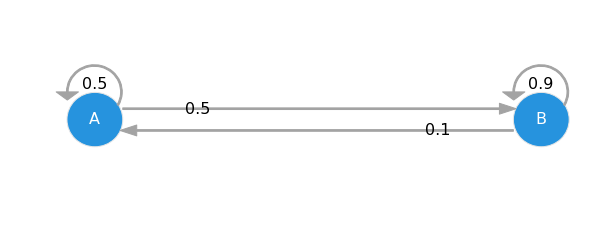

In [2]:
P = np.array([[0.5, 0.5], 
              [0.1, 0.9]]) 
mc = MarkovChain(P, ['A', 'B'])
mc.draw()

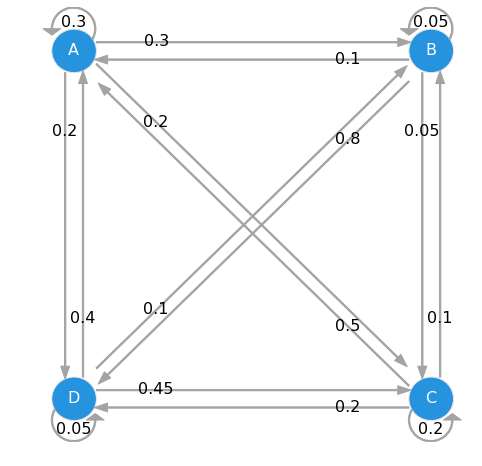

In [3]:
P = np.array([[0.3, 0.3, 0.2, 0.2], 
              [0.1, 0.05, 0.05, 0.8],
              [0.5, 0.1, 0.2, 0.2],
              [0.4, 0.1, 0.45, 0.05]
             ]) 
mc = MarkovChain(P, ['A', 'B', 'C', 'D'])
mc.draw()

## Markov chain application

The example is based on Fraud detection. Assuming that we have 1-year performance of portfolio, we can compute the path (i.e. P(Good Loans -> Bad Loans) = 3%) and construct the transition matrix, in this example, based on the portfolio, we can have Good Loans, Risky Loans, Bad Loans, and Paid-Up.


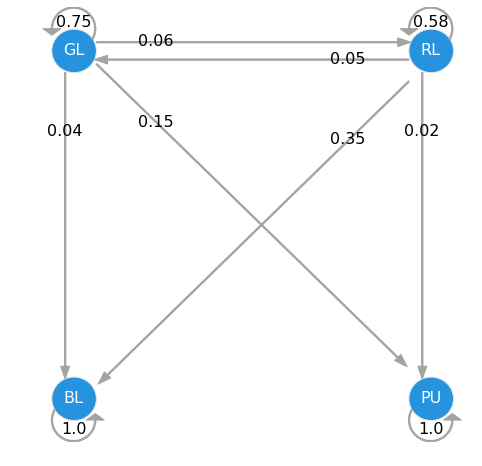

In [4]:
P = np.array([[0.75, 0.06, 0.15, 0.04], 
              [0.05, 0.58, 0.02, 0.35],
              [0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]
             ]) 
mc = MarkovChain(P, ['GL', 'RL', 'PU', 'BL'])
mc.draw()

Now let's simulate three different portfolios

In [5]:
portA = np.array([0.9, 0.1, 0, 0])
portB = np.array([0.5, 0.5, 0, 0])
portC = np.array([0.2, 0.8, 0, 0])

In [6]:
def simulate_loan_result(port: np.ndarray, n_year: int):
    print(f'Starting port consists of Good loans: {port[0]}, risky loan: {port[1]}')
    for i in range(1, n_year+1):
        if i == 1:
            _out = np.dot(port, P)
        
        else:
            _out = np.dot(_out, P)
            
        _out = np.round(_out, 6)
        print(f'Year {i}: probs are {_out}; Paid up: {_out[2]}, Bad Loan: {_out[3]}')
        
    return None



In [7]:
portA = np.array([0.9, 0.1, 0, 0])
portB = np.array([0.5, 0.5, 0, 0])
portC = np.array([0.2, 0.8, 0, 0])

simulate_loan_result(portA, 10)
simulate_loan_result(portB, 10)
simulate_loan_result(portC, 10)

Starting port consists of Good loans: 0.9, risky loan: 0.1
Year 1: probs are [0.68  0.112 0.137 0.071]; Paid up: 0.137, Bad Loan: 0.071
Year 2: probs are [0.5156  0.10576 0.24124 0.1374 ]; Paid up: 0.24124, Bad Loan: 0.1374
Year 3: probs are [0.391988 0.092277 0.320695 0.19504 ]; Paid up: 0.320695, Bad Loan: 0.19504
Year 4: probs are [0.298605 0.07704  0.381339 0.243016]; Paid up: 0.381339, Bad Loan: 0.243016
Year 5: probs are [0.227806 0.062599 0.427671 0.281924]; Paid up: 0.427671, Bad Loan: 0.281924
Year 6: probs are [0.173984 0.049976 0.463094 0.312946]; Paid up: 0.463094, Bad Loan: 0.312946
Year 7: probs are [0.132987 0.039425 0.490191 0.337397]; Paid up: 0.490191, Bad Loan: 0.337397
Year 8: probs are [0.101712 0.030846 0.510928 0.356515]; Paid up: 0.510928, Bad Loan: 0.356515
Year 9: probs are [0.077826 0.023993 0.526802 0.37138 ]; Paid up: 0.526802, Bad Loan: 0.37138
Year 10: probs are [0.059569 0.018586 0.538956 0.382891]; Paid up: 0.538956, Bad Loan: 0.382891
Starting port con

## Hidden Markov model for Regime Detection

Let's see how HMM can be used in quantitative finance. Considering that the largest issue we face when trying to apply predictive techniques to asset returns is __nonstationary time series__. In brief, this means that the expected mean and volatility of asset returns changes over time.

Most of the time series models and techniques assume that the data is stationary, which is a major weakness of these models.

<br>

Instead, let's frame the problem differently, we know that the time series exhibit temporary periods where the expected means and variances are stable through time. __These periods or regimes can be linked to hidden states of HMM__.

If that is the case, then all we need are observable variables whose behavior allows us to _infer_ the true hidden states. If we can better estimate an asset's most likely regime, including the associated means and variances, then our predictive models become more adaptable and will likely improve. We can also use the estimated regime parameters for better scenario analysis.

<br>

In this example, the observable variables I use are: the underlying asset returns, the ICE BofA US High Yield Index Total Return Index, the Ted Spread, the 10 year - 2 year constant maturity spread, and the 10 year - 3 month constant maturity spread.

Getting the stock data starting from 2010 onwards

,TEDRATE,T10Y2Y,T10Y3M,BAMLHYH0A0HYM2TRIV,GE,sret
2010-01-04,0.17,2.76,3.77,687.56,10.733057,0.020930
2010-01-05,0.18,2.76,3.70,690.89,10.788632,0.005165
2010-01-06,0.19,2.84,3.79,694.03,10.733057,-0.005165
2010-01-07,0.20,2.82,3.80,697.44,11.288810,0.050484
2010-01-08,0.20,2.87,3.78,698.79,11.531955,0.021310


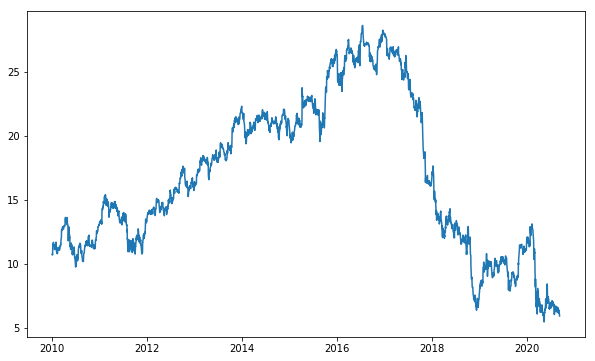

In [8]:
mkt = 'GE'  # stock to watch
f1 = 'TEDRATE' # ted spread (ref: https://fred.stlouisfed.org/series/TEDRATE)
f2 = 'T10Y2Y' # constant maturity ten yer - 2 year
f3 = 'T10Y3M' # constant maturity 10yr - 3m
f4 = 'BAMLHYH0A0HYM2TRIV'  # ICE BofA US High Yield Index Total Return Index Value

start = datetime.date(2010, 1, 1)
end = datetime.date.today()

mkt_df = web.DataReader([mkt], 'yahoo', start, end)['Adj Close']\
    .rename(columns={mkt: mkt})\
    .assign(sret=lambda x: np.log(x[mkt] / x[mkt].shift(1)))\
    .dropna()

data_df = web.DataReader([f1, f2, f3, f4], 'fred', start, end)\
    .join(mkt_df, how='inner')\
    .dropna()

display(data_df.head(5))
plt.figure(figsize=(10, 6))
plt.plot(data_df[mkt])
plt.show()

In this notebook, I will try using 2 methods: `sklearn's GaussianMixture` and `HMMLearn's GaussianHMM`.

<br>

Both models require us to specify the number of components to fit to the time series, these components can be thought of as regimes. For this specific example, we will assign 3 components and assume to be high, neural and low volatility.

In [9]:
N_COMPONENTS = 3
COL_ = 'sret'
FT_COLS = [f1, f2, f3, f4, COL_]

def plot_in_sample_hidden_states(hmm_model, df, 
                                 stock_col: str=mkt, return_col: str='sret'):
    """
    Plot the adjusted closing prices masked by 
    the in-sample hidden states as a mechanism
    to understand the market regimes.
    """
    sret = np.column_stack([df[FT_COLS].values])
    hidden_states = hmm_model.predict(sret)
    
    fig, axs = plt.subplots(hmm_model.n_components, sharex=True, sharey=True,
                            figsize=(18, 14))
    colours = cm.rainbow(np.linspace(0, 1, hmm_model.n_components))
    
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        mask = hidden_states == i
        ax.plot_date(
            df.index[mask], 
            df.loc[:, stock_col][mask], 
            ".", linestyle='none', 
            c=colour
        )
        ax.set_title("Hidden State #%s" % i)
        ax.xaxis.set_major_locator(YearLocator())
        ax.xaxis.set_minor_locator(MonthLocator())
        ax.grid(True)
        
    plt.show()
    return



### Gaussian Mixture

We can `sklearn's GausianMixture` to fit the model that estimates these regimes. The mixture models implement a closely related unsupervised form of density estimation by utilizing the expectation-maximization algorithm to estimate the means and covariances of the hidden states.

Means and vars of each hidden state
0th hidden state
mean:  [   0.24491265    1.71393026    2.13706315 1023.64314591    0.00044678]
var:  [   0.00366962    0.20377661    0.17732556 2478.32230409    0.00012494]

1th hidden state
mean:  [  0.28091984   2.22513776   2.63867434 796.9280131    0.00059286]
var:  [   0.01520551    0.23967626    0.47549917 3318.88528221    0.00029243]

2th hidden state
mean:  [   0.37893448    0.72545989    1.22761507 1226.50018711   -0.0019462 ]
var:  [   0.01344434    0.10990187    0.12526898 2566.23861886    0.00033528]



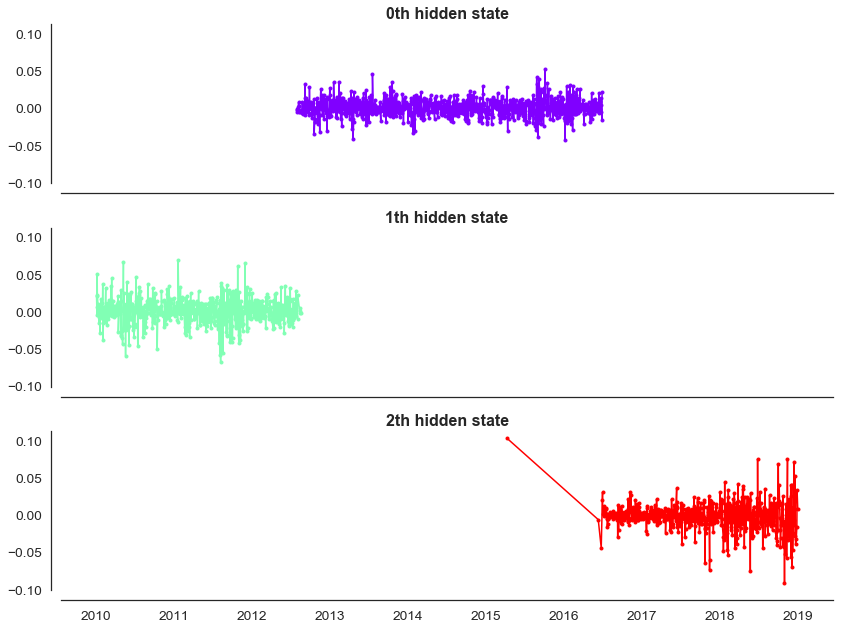

In [10]:
train_df = data_df.loc[: '2019-01-01'].dropna()
test_df = data_df.loc['2019-01-01': ].dropna()
X_train = train_df[FT_COLS].values
X_test = test_df[FT_COLS].values

model = mix.GaussianMixture(n_components=N_COMPONENTS, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=SEED).fit(X_train)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X_train)

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print(f'{i}th hidden state')
    print('mean: ', (model.means_[i]))
    print('var: ', np.diag(model.covariances_[i]))
    print()

sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3, 'legend.frameon': True}
sns.set_style('white', style_kwds)

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(12,9))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(train_df.index.values[mask],
                 train_df[COL_].values[mask],
                 ".-", c=color)
    ax.set_title("{0}th hidden state".format(i), fontsize=16, fontweight='demi')

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    sns.despine(offset=10)

plt.tight_layout()

We can refer to the last position in `mean` and `var` values, which referred to log return of the stock. This is the daily expected mean and variance of GE stock returns.

<br>

It appears the 1st hidden state represent the neutral volatility, the largest expected return and medium variance. The last hidden state represents the high volatility regime, with the highest variance with negative returns.

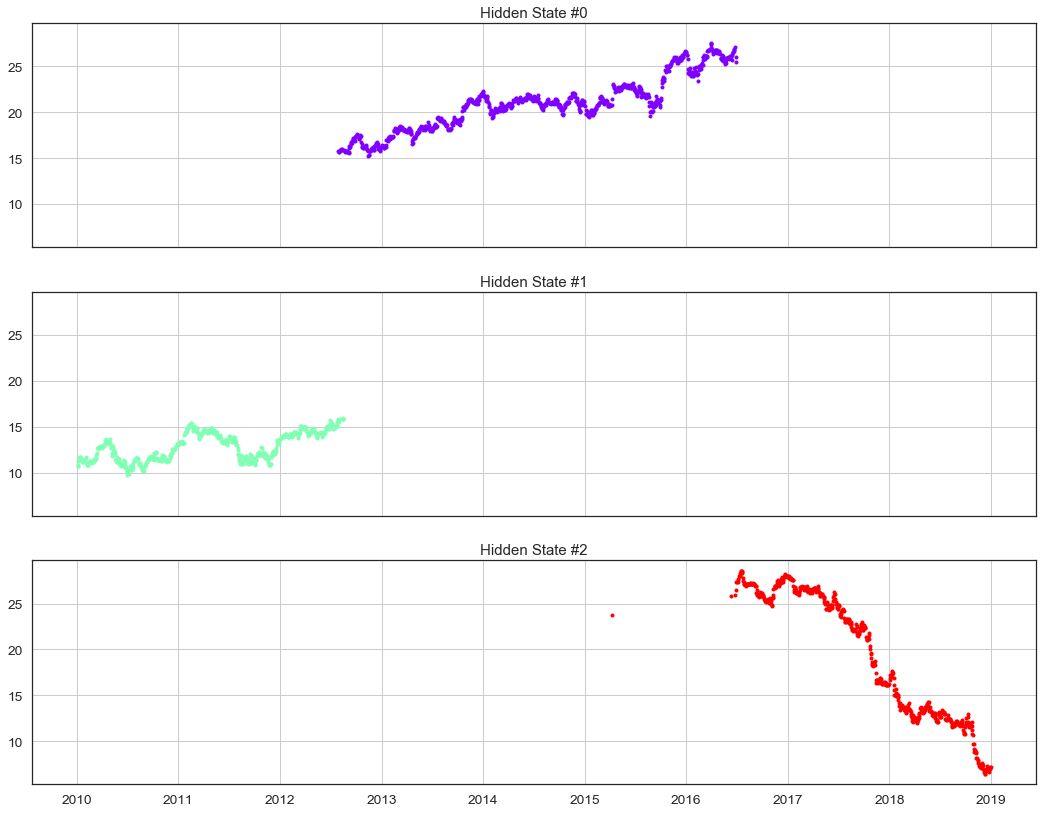

In [11]:
plot_in_sample_hidden_states(model, train_df)

,Date,states,TEDRATE,T10Y2Y,T10Y3M,BAMLHYH0A0HYM2TRIV,GE,sret,mkt_cret
0,2010-01-04,1,0.17,2.76,3.77,687.56,10.733057,0.020930,0.020930
1,2010-01-05,1,0.18,2.76,3.70,690.89,10.788632,0.005165,0.026094
2,2010-01-06,1,0.19,2.84,3.79,694.03,10.733057,-0.005165,0.020930
3,2010-01-07,1,0.20,2.82,3.80,697.44,11.288810,0.050484,0.071413
4,2010-01-08,1,0.20,2.87,3.78,698.79,11.531955,0.021310,0.092723


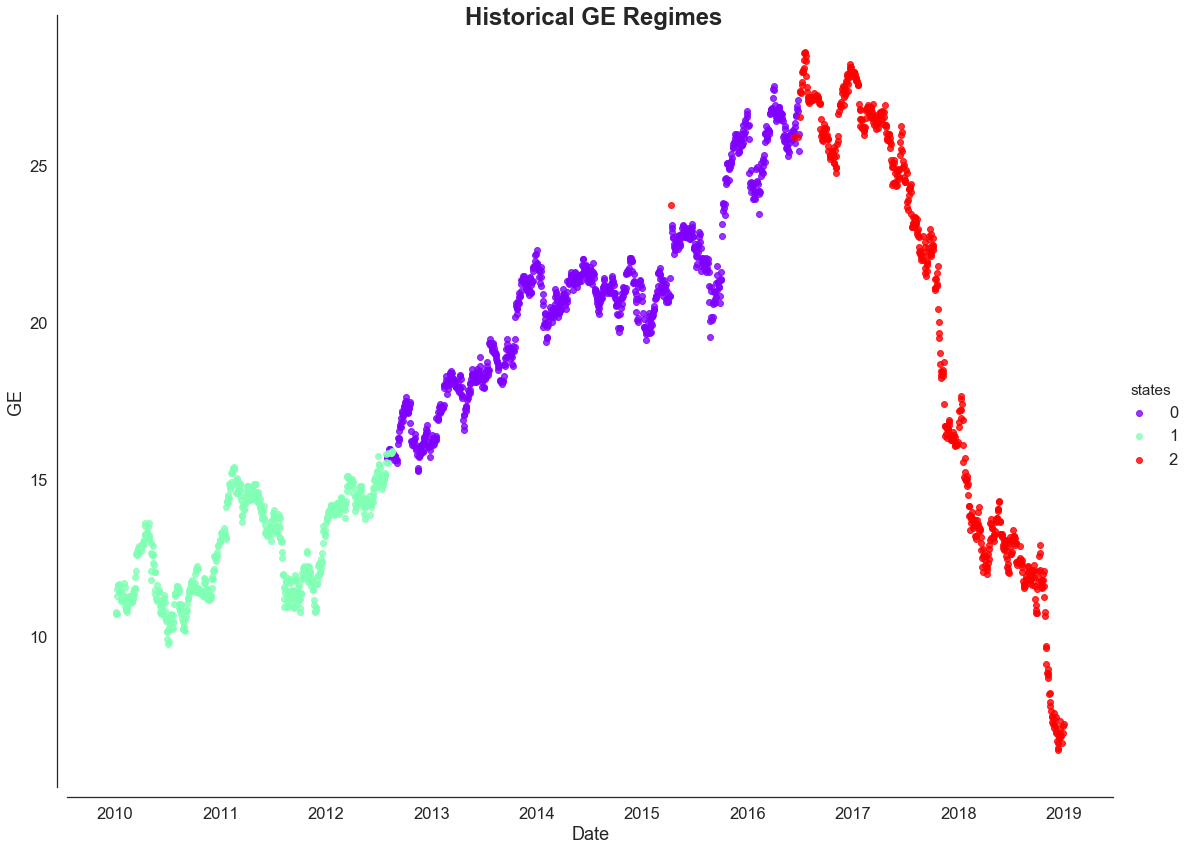

In [12]:
sns.set(font_scale=1.5)
states = (pd.DataFrame(hidden_states, columns=['states'], index=train_df.index)
          .join(train_df, how='inner')
          .assign(mkt_cret=train_df.sret.cumsum())
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
display(states.head())

sns.set_style('white', style_kwds)
order = np.arange(model.n_components)
fg = sns.FacetGrid(data=states, hue='states', hue_order=order,
                   palette=colors, aspect=1.31, height=12)
fg.map(plt.scatter, 'Date', mkt, alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle(f'Historical {mkt} Regimes', fontsize=24, fontweight='demi')
plt.show()

,Date,states,TEDRATE,T10Y2Y,T10Y3M,BAMLHYH0A0HYM2TRIV,GE,sret,mkt_cret
0,2019-01-02,2,0.42,0.16,0.24,1234.57,7.690249,0.061479,0.061479
1,2019-01-03,2,0.44,0.17,0.15,1236.01,7.699802,0.001241,0.062720
2,2019-01-04,2,0.43,0.17,0.25,1249.58,7.862205,0.020873,0.083593
3,2019-01-07,2,0.39,0.17,0.25,1259.24,8.349413,0.060124,0.143717
4,2019-01-08,2,0.37,0.15,0.27,1265.77,8.177457,-0.020810,0.122907


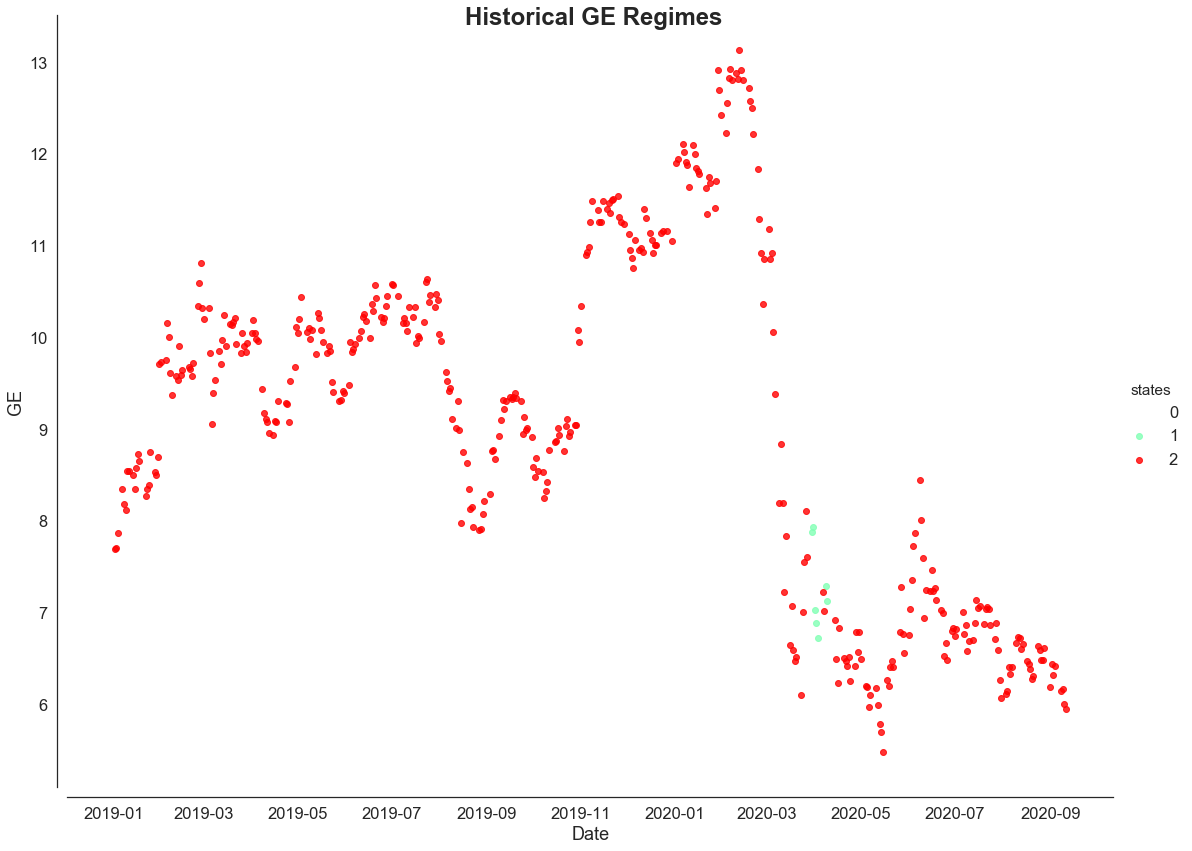

In [13]:
hidden_states_test = model.predict(X_test)
sns.set(font_scale=1.5)
states = (pd.DataFrame(hidden_states_test, columns=['states'], index=test_df.index)
          .join(test_df, how='inner')
          .assign(mkt_cret=test_df.sret.cumsum())
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
display(states.head())

sns.set_style('white', style_kwds)
order = np.arange(model.n_components)
fg = sns.FacetGrid(data=states, hue='states', hue_order=order,
                   palette=colors, aspect=1.31, height=12)
fg.map(plt.scatter, 'Date', mkt, alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle(f'Historical {mkt} Regimes', fontsize=24, fontweight='demi')
plt.show()

### HMMLearn Gaussian HMM

For more information on the library, please refer to this [link](https://hmmlearn.readthedocs.io/en/latest/).

Means and vars of each hidden state
0th hidden state
mean:  [   0.23302032    1.7726992     2.19477445 1023.32417097    0.00049585]
var:  [   0.00223758    0.17899452    0.15339612 2221.03529757    0.00014059]

1th hidden state
mean:  [  0.2824665    2.20007519   2.60616172 799.94536338   0.00058258]
var:  [   0.01485633    0.25386443    0.49726499 3527.98924267    0.00029987]

2th hidden state
mean:  [   0.37959073    0.7488505     1.25275492 1212.23437408   -0.0017892 ]
var:  [   0.01234217    0.1060428     0.12149091 4445.24969468    0.00032578]



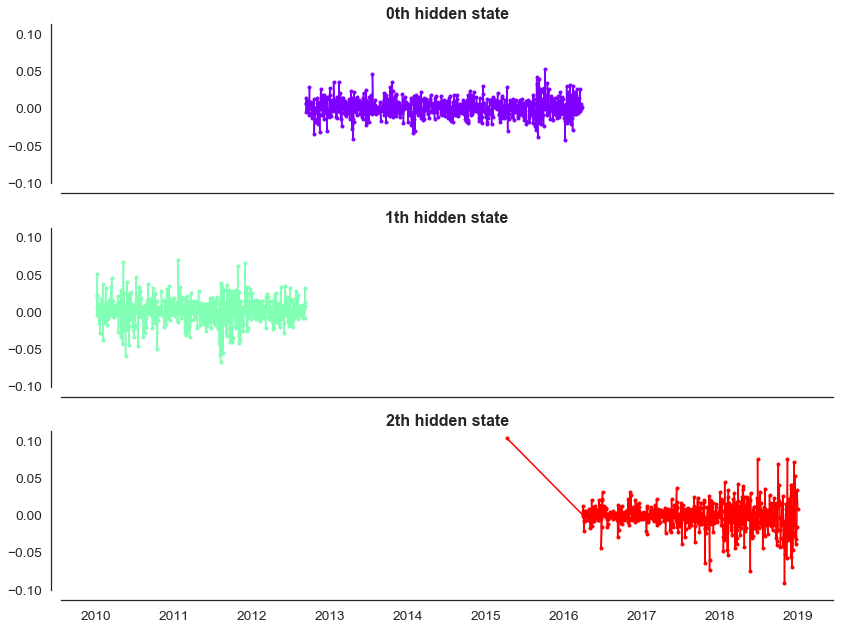

In [14]:
_df = np.column_stack([train_df[FT_COLS].values])
hmm_model = GaussianHMM(n_components=3, covariance_type="full", 
                        n_iter=1000, random_state=SEED).fit(_df)
hidden_states = hmm_model.predict(_df)
print("Means and vars of each hidden state")
for i in range(hmm_model.n_components):
    print(f'{i}th hidden state')
    print('mean: ', (hmm_model.means_[i]))
    print('var: ', np.diag(hmm_model.covars_[i]))
    print()

sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3, 'legend.frameon': True}
sns.set_style('white', style_kwds)

fig, axs = plt.subplots(hmm_model.n_components, sharex=True, sharey=True, figsize=(12,9))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(train_df.index.values[mask],
                 train_df[COL_].values[mask],
                 ".-", c=color)
    ax.set_title("{0}th hidden state".format(i), fontsize=16, fontweight='demi')

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    sns.despine(offset=10)

plt.tight_layout()

,Date,states,TEDRATE,T10Y2Y,T10Y3M,BAMLHYH0A0HYM2TRIV,GE,sret,mkt_cret
0,2010-01-04,1,0.17,2.76,3.77,687.56,10.733057,0.020930,0.020930
1,2010-01-05,1,0.18,2.76,3.70,690.89,10.788632,0.005165,0.026094
2,2010-01-06,1,0.19,2.84,3.79,694.03,10.733057,-0.005165,0.020930
3,2010-01-07,1,0.20,2.82,3.80,697.44,11.288810,0.050484,0.071413
4,2010-01-08,1,0.20,2.87,3.78,698.79,11.531955,0.021310,0.092723


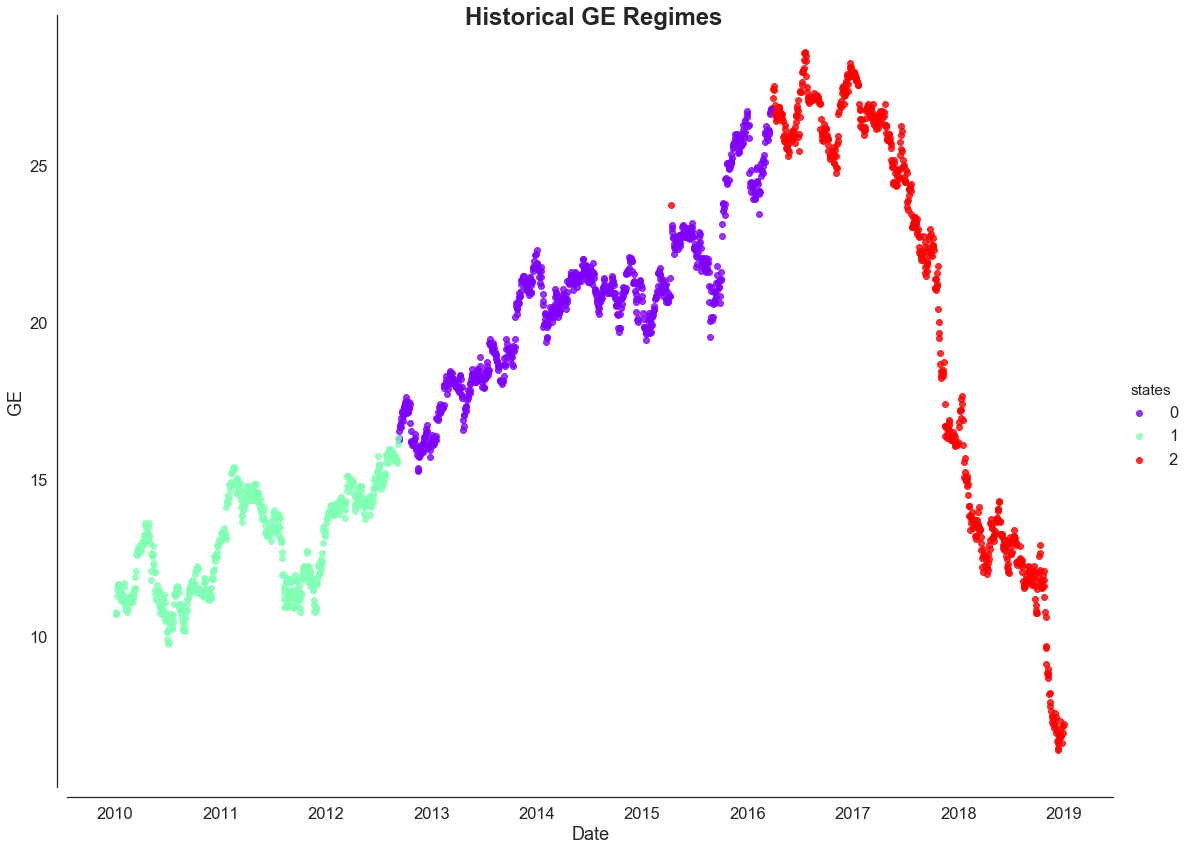

In [15]:
sns.set(font_scale=1.5)
states = (pd.DataFrame(hidden_states, columns=['states'], index=train_df.index)
          .join(train_df, how='inner')
          .assign(mkt_cret=train_df.sret.cumsum())
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
display(states.head())

sns.set_style('white', style_kwds)
order = np.arange(hmm_model.n_components)
fg = sns.FacetGrid(data=states, hue='states', hue_order=order,
                   palette=colors, aspect=1.31, height=12)
fg.map(plt.scatter, 'Date', mkt, alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle(f'Historical {mkt} Regimes', fontsize=24, fontweight='demi')
plt.show()

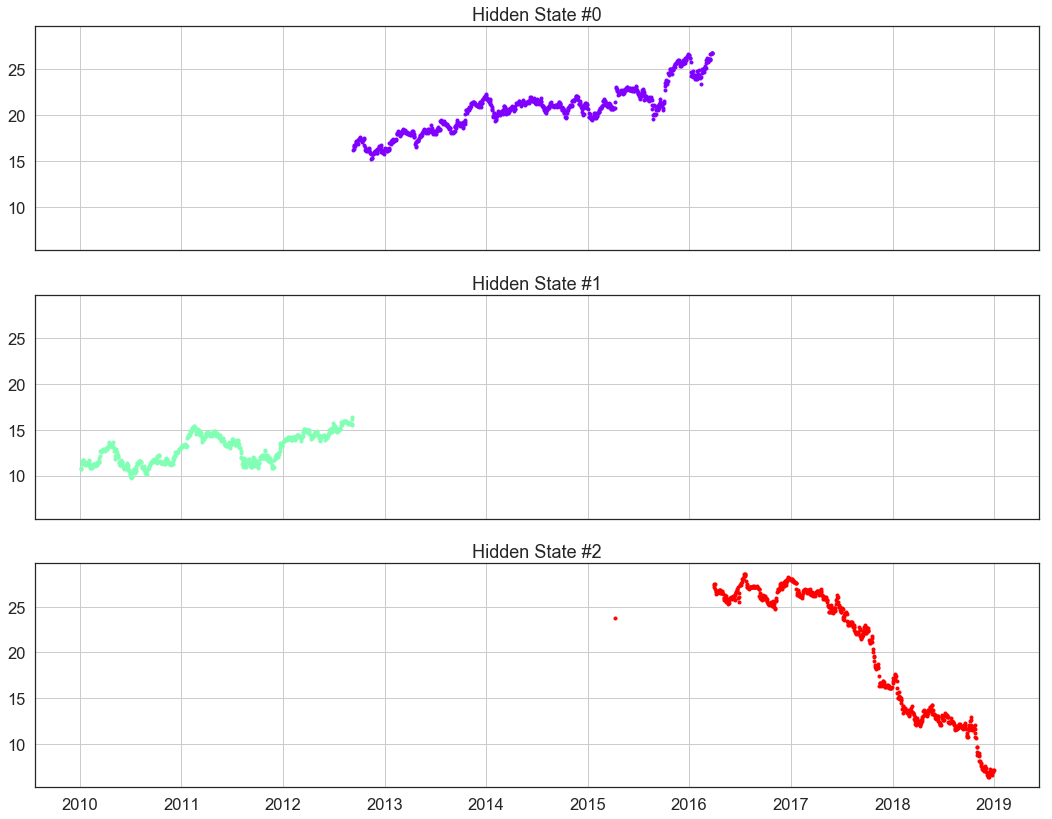

In [16]:
plot_in_sample_hidden_states(hmm_model, train_df)

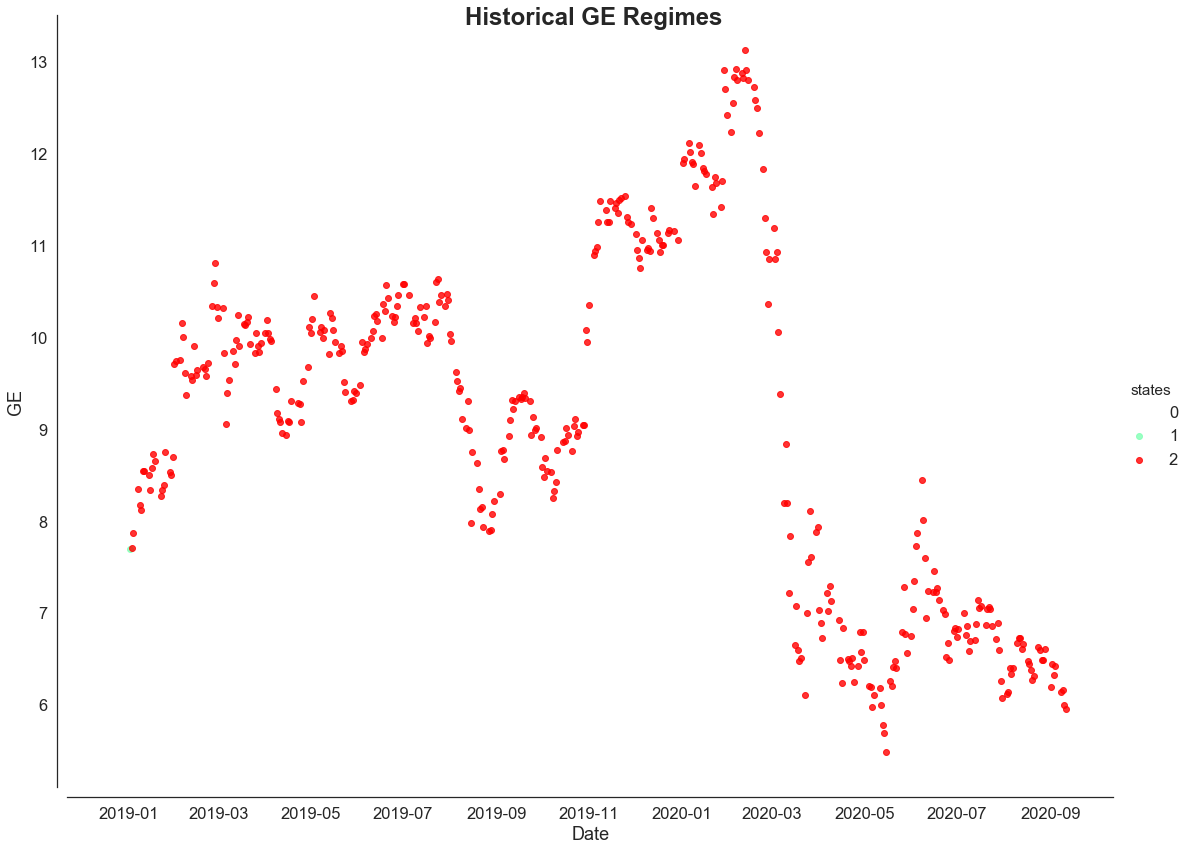

In [17]:
_df = np.column_stack([test_df[FT_COLS].values])
hidden_states_test = hmm_model.predict(_df)
sns.set(font_scale=1.5)
states = (pd.DataFrame(hidden_states_test, columns=['states'], index=test_df.index)
          .join(test_df, how='inner')
          .assign(mkt_cret=test_df.sret.cumsum())
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))

sns.set_style('white', style_kwds)
order = np.arange(model.n_components)
fg = sns.FacetGrid(data=states, hue='states', hue_order=order,
                   palette=colors, aspect=1.31, height=12)
fg.map(plt.scatter, 'Date', mkt, alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle(f'Historical {mkt} Regimes', fontsize=24, fontweight='demi')
plt.show()